#### By exploring the bike ride share data, we will try to find answers for the below questions through thorough exploratory data analysis and predictive modelling.

For this project, we have used the data from Metro Bike Share in the city of Los Angeles, California that makes bikes available 24/7, 365 days a year in Downtown LA, Central LA, Port of LA and Westside. They started their operations during the second quarter of 2016.
Based on this scenario, the project answers key questions e.g. a review of the quality of the available data, assumptions made, implications from revenue, tickets and pass-types, trip duration, number of trips by region and weather.

Data Files:
Trip and station data is collected from [LA Metro Bike Share website](https://bikeshare.metro.net/about/data/). The station details are updated as of 1/4/2019 and the trip data ranges from 2018 Q1 to 2019 Q1.
* Station data 
    metro-bike-share-stations-2019-04-01.csv
* Trip data
    metro-bike-share-trips-2018-q1.csv, 
    metro-bike-share-trips-2018-q2.csv,
    metro-bike-share-trips-2018-q3.csv,
    metro-bike-share-trips-2018-q4.csv,
    metro-bike-share-trips-2019-q1.csv
             
Weather data is collected from [NOAA website](https://www.noaa.gov/weather). The date range overlaps the trip data, i.e. 1/1/2018 - 1/31/2019.
* Weather data
    WeatherLA.csv
    
## Analysis and model building

In [1]:
# standard library imports
import pandas as pd
import numpy as np
import warnings
import sys
#import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats

# third party imports

# suppress warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# graph output
%matplotlib inline

### Data Preparation: Data Load and merging

In [2]:
# read in the csv data files

def getdata_csv(file):
    '''
    Args:
        csv file name
    Output:
        dataframe of the csv data
    '''

    outdf = pd.read_csv(file)
    return outdf

# read station data
station = getdata_csv('data/metro-bike-share-stations-2019-04-01.csv')

# read quarterly trip data
quarter1 = getdata_csv('data/metro-bike-share-trips-2018-q1.csv')
quarter2 = getdata_csv('data/metro-bike-share-trips-2018-q2.csv')
quarter3 = getdata_csv('data/metro-bike-share-trips-2018-q3.csv')
quarter4 = getdata_csv('data/metro-bike-share-trips-2018-q4.csv')
quarter5 = getdata_csv('data/metro-bike-share-trips-2019-q1.csv')

# concatenate the quarterly trip data into one dataframe
trip = quarter5.append(quarter4, ignore_index=True, sort=False) \
.append(quarter3, ignore_index=True, sort=False) \
.append(quarter2, ignore_index=True, sort=False) \
.append(quarter1, ignore_index=True, sort=False)

In [3]:
# check the station data
station.head()

,Station_ID,Station_Name,Go_live_date,Region,Status
0,3000,Virtual Station,7/7/2016,NaN,Active
1,3005,7th & Flower,7/7/2016,DTLA,Active
2,3006,Olive & 8th,7/7/2016,DTLA,Active
3,3007,5th & Grand,7/7/2016,DTLA,Active
4,3008,Figueroa & 9th,7/7/2016,DTLA,Active


In [4]:
# check the combined trip data
trip.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,112536773,7,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,06468,1,One Way,Walk-up,standard
1,112536772,6,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,12311,1,One Way,Walk-up,standard
2,112538689,32,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,05992,1,One Way,Walk-up,standard
3,112538688,30,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,05860,1,One Way,Walk-up,standard
4,112538687,28,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,06006,1,One Way,Walk-up,standard


#### Merge trip and station data

Add important station information in trip data to create a unified dataset for further analysis

In [5]:
# unnecessary columns from station data
columns = ['Station_ID','Station_Name','Go_live_date']

# add start station info
result = pd.merge(trip,
                  station,
                  left_on = 'start_station', 
                  right_on = 'Station_ID',
                  how='left').rename(index=str, columns={'Region ': 'start_region', 'Status': 'start_status'})

# remove unnecessary columns of station data
result.drop(columns, inplace=True, axis=1)

# add end station info
result = pd.merge(result,
                  station,
                  left_on = 'end_station', 
                  right_on = 'Station_ID',
                  how='left').rename(index=str, columns={'Region ': 'end_region', 'Status': 'end_status'})

# remove unnecessary columns of station data
result.drop(columns, inplace=True, axis=1)

# final result of combined station and trip data
result.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,start_region,start_status,end_region,end_status
0,112536773,7,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,06468,1,One Way,Walk-up,standard,DTLA,Active,DTLA,Active
1,112536772,6,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,12311,1,One Way,Walk-up,standard,DTLA,Active,DTLA,Active
2,112538689,32,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,05992,1,One Way,Walk-up,standard,DTLA,Active,DTLA,Active
3,112538688,30,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,05860,1,One Way,Walk-up,standard,DTLA,Active,DTLA,Active
4,112538687,28,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,06006,1,One Way,Walk-up,standard,DTLA,Active,DTLA,Active


#### Merge weather data

Weather data of LA weather stations for the 2018Q1 - 2019Q1 timeframe has been collected from National Oceanic and Atmospheric Administration (NOAA) website.

In [6]:
# load the LA weather data
weather = getdata_csv('data/LATemp.csv')

# check the first five rows of the weather data
weather.head()

,Unnamed: 0,DATE,TMIN,TAVG,TMAX
0,731,2018-01-01,48.535714,58.910714,70.392857
1,732,2018-01-02,53.321429,64.000000,76.357143
2,733,2018-01-03,54.000000,63.035714,72.142857
3,734,2018-01-04,52.785714,62.250000,73.500000
4,735,2018-01-05,52.857143,61.535714,71.607143


In [7]:
# drop unnecessary columns
weather = weather.drop(columns=['Unnamed: 0'])

# standerdize the column names
weather = weather.rename(columns={'DATE': 'date', 'TMIN': 'tmin', 'TAVG': 'tavg', 'TMAX': 'tmax'})

# Checking the data types for the result data frame
result.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_station            int64
start_lat              float64
start_lon              float64
end_station              int64
end_lat                float64
end_lon                float64
bike_id                 object
plan_duration            int64
trip_route_category     object
passholder_type         object
bike_type               object
start_region            object
start_status            object
end_region              object
end_status              object
dtype: object

In [8]:
# convert the start_time and end_time into date object
result['start_time'] = pd.to_datetime(result['start_time'])
result['end_time'] = pd.to_datetime(result['end_time'])

# check the data types to make sure its converted into date time object
result.dtypes

trip_id                         int64
duration                        int64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_station                   int64
start_lat                     float64
start_lon                     float64
end_station                     int64
end_lat                       float64
end_lon                       float64
bike_id                        object
plan_duration                   int64
trip_route_category            object
passholder_type                object
bike_type                      object
start_region                   object
start_status                   object
end_region                     object
end_status                     object
dtype: object

In [9]:
# converting the date in the weather data frame to datetime object
weather['date'] = pd.to_datetime(weather['date'])

# checking to make sure the date is in date time object
weather.dtypes

date    datetime64[ns]
tmin           float64
tavg           float64
tmax           float64
dtype: object

In [10]:
# filter the weather data frame to contain the values only upto the firts quarter of the year 2019
weather_to2019Q1 = weather[weather['date'] <= '2019-03-31']

# check the head of the Date column in weather
print('Head:') 
print(weather_to2019Q1.sort_values(by ='date').date.head())

# check the tail of the Date column in weather
print('Tail:') 
print(weather_to2019Q1.sort_values(by ='date').date.tail())

Head:
0   2018-01-01
1   2018-01-02
2   2018-01-03
3   2018-01-04
4   2018-01-05
Name: date, dtype: datetime64[ns]
Tail:
450   2019-03-27
451   2019-03-28
452   2019-03-29
453   2019-03-30
454   2019-03-31
Name: date, dtype: datetime64[ns]


In [11]:
# extract the date from the date time object and creating a DATE column 
result['date'] = pd.to_datetime(result['start_time']).dt.date

# check the head of the Date column in result
result.sort_values(by = 'date').date.head()

304639    2018-01-01
304379    2018-01-01
304380    2018-01-01
304381    2018-01-01
304382    2018-01-01
Name: date, dtype: object

In [12]:
# check the head of the Date column in result
result.sort_values(by = 'date').date.tail()

56996    2019-03-31
56997    2019-03-31
56998    2019-03-31
56992    2019-03-31
56841    2019-03-31
Name: date, dtype: object

In [13]:
result['date'] = pd.to_datetime(result['date'])

# since the two data frames have the same column 'DATE', we will join the data frame by DATE
trip_merged = pd.merge(result, weather_to2019Q1)

# Check the head of the top five rows of the combined data frame
trip_merged[['trip_id','date','tmin', 'tavg', 'tmax']].head()

,trip_id,date,tmin,tavg,tmax
0,112536773,2019-01-01,39.888889,47.851852,55.740741
1,112536772,2019-01-01,39.888889,47.851852,55.740741
2,112538689,2019-01-01,39.888889,47.851852,55.740741
3,112538688,2019-01-01,39.888889,47.851852,55.740741
4,112538687,2019-01-01,39.888889,47.851852,55.740741


In [14]:
# check the tail of the last five rows of the combined data frame
trip_merged[['trip_id','date','tmin', 'tavg', 'tmax']].tail()

,trip_id,date,tmin,tavg,tmax
369247,79626925,2018-03-31,52.428571,61.892857,72.428571
369248,79626924,2018-03-31,52.428571,61.892857,72.428571
369249,79626923,2018-03-31,52.428571,61.892857,72.428571
369250,79626922,2018-03-31,52.428571,61.892857,72.428571
369251,79626921,2018-03-31,52.428571,61.892857,72.428571


In [15]:
# checkpoint - the analysis could be resumed from here
# write the final dataset to a csv file for future load
trip_merged.to_csv('data/Bikesharing-Weather-Combined.csv')

We faced two roadblocks while integrating the wethaer data.

1. Weather data was not at the same grain with station location in terms of zip code.

2. Zip code level weather data is available but we could not find zip code level trip data.

Resolution:
We took average of the daily meteorological attributes and applied to the trip data. 

In [16]:
trip_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369252 entries, 0 to 369251
Data columns (total 23 columns):
trip_id                369252 non-null int64
duration               369252 non-null int64
start_time             369252 non-null datetime64[ns]
end_time               369252 non-null datetime64[ns]
start_station          369252 non-null int64
start_lat              367976 non-null float64
start_lon              367976 non-null float64
end_station            369252 non-null int64
end_lat                362698 non-null float64
end_lon                362698 non-null float64
bike_id                369252 non-null object
plan_duration          369252 non-null int64
trip_route_category    369252 non-null object
passholder_type        369252 non-null object
bike_type              131225 non-null object
start_region           368247 non-null object
start_status           369197 non-null object
end_region             363120 non-null object
end_status             369204 non-null object


### Exploratory Data Analysis (EDA)

In the EDA, we decided to discover various causal relationship between the attributes. This will include:

1. Initial Data Profiling

2. Plotting correlation matrix

3. Total rides by membership type

4. Average trip duration by membership type

5. Top 5 stations with the most starts (showing # of starts)

6. Plot of active stations

7. Most Popular Trip

8. Bike traffic throughout the year

#### 1. Initial Data Profiling

Looking for basic data distribution.

In [17]:
round(trip_merged.describe(),2)

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,plan_duration,tmin,tavg,tmax
count,3.692520e+05,369252.00,369252.00,367976.00,367976.00,369252.00,362698.00,362698.00,369252.00,369252.00,369252.00,369252.00
mean,9.731025e+07,40.12,3387.71,34.04,-118.29,3383.35,34.04,-118.29,31.05,55.26,64.53,74.78
std,1.505842e+07,132.47,532.86,0.06,0.10,531.97,0.06,0.10,70.53,8.35,9.00,10.24
min,6.540635e+07,1.00,3000.00,33.71,-118.49,3000.00,33.71,-118.49,0.00,36.32,44.52,52.37
25%,8.502398e+07,7.00,3030.00,34.04,-118.27,3030.00,34.04,-118.27,1.00,49.25,58.14,67.07
50%,1.025874e+08,13.00,3058.00,34.05,-118.25,3055.00,34.05,-118.25,30.00,54.50,63.96,74.79
75%,1.092788e+08,28.00,4157.00,34.05,-118.24,4157.00,34.05,-118.24,30.00,61.27,71.71,82.61
max,1.188434e+08,1440.00,4385.00,34.17,-118.12,4382.00,34.17,-118.12,999.00,77.19,89.56,106.74


#### 2. Plotting correlation matrix

Find correlation between the numeric fields to have idea between existing relationship in the data. 

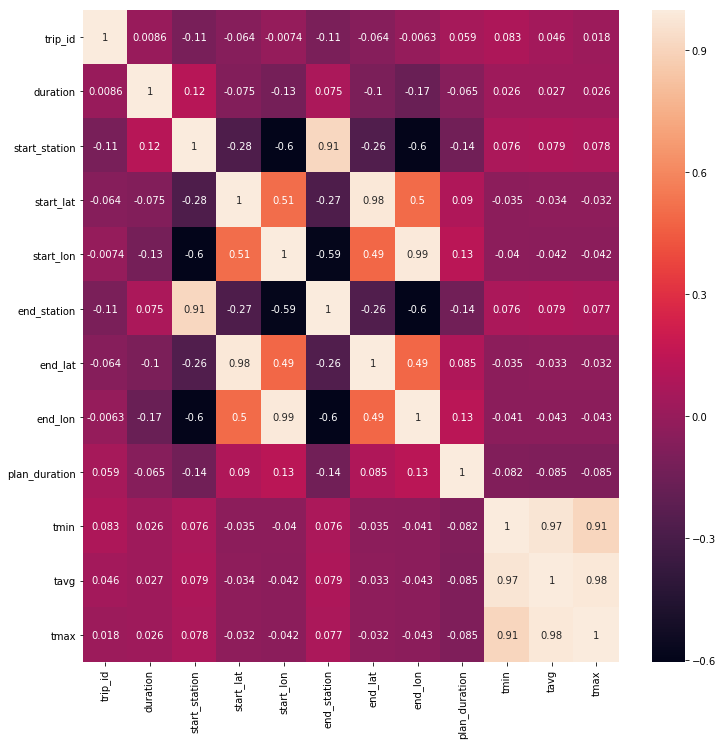

In [18]:
plt.figure(figsize = (12,12))
# Correlation Matrix
sns.heatmap(trip_merged \
            .drop(columns=['passholder_type','bike_type','start_region','start_status','end_region','end_status']) \
            .corr(), annot=True)

# since we need to correlation graph a bit larger for easy interpretation, change the output size
plt.rcParams["figure.figsize"] = (12,12)

plt.show()

Some of the attributes show strong correlation e.g. `end_lat` vs `start_lat`, `end_lon` vs `start_lon` etc. But those are mostly because of the trips those started and ended at the same station. We were looking for correlation between trip attributes and weather attributes but no such strong correlation exist. Therefore the data needs further investigation.

#### 3. Total rides by membership type

In [19]:
trip_merged.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'start_region', 'start_status', 'end_region', 'end_status',
       'date', 'tmin', 'tavg', 'tmax'],
      dtype='object')

In [20]:
countsbypasstype = trip_merged.groupby(['passholder_type']).trip_id.count().reset_index(name='counts')
countsbypasstype.columns

Index(['passholder_type', 'counts'], dtype='object')

In [21]:
countsbypasstype

,passholder_type,counts
0,Annual Pass,5876
1,Flex Pass,7021
2,Monthly Pass,190987
3,One Day Pass,20108
4,Testing,11
5,Walk-up,145249


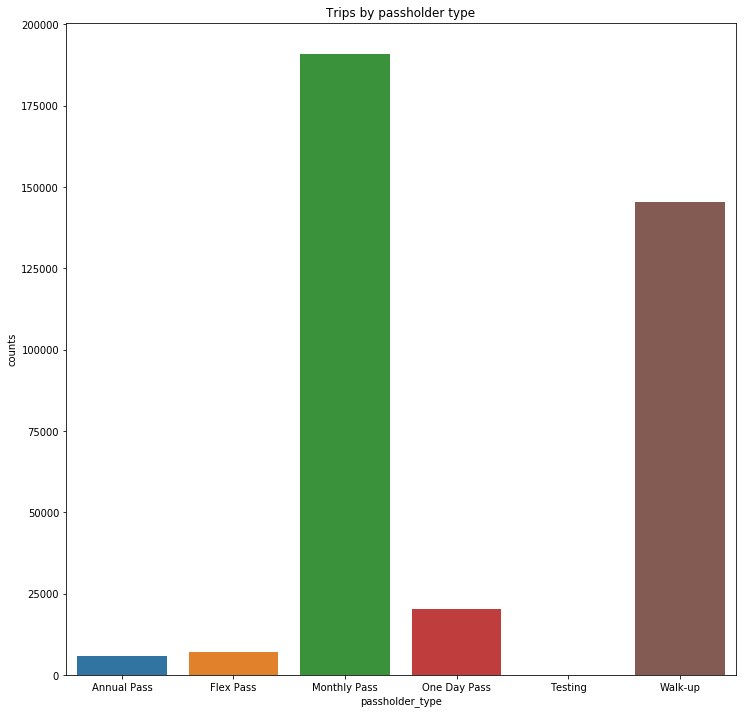

In [22]:
#plot the bar chart

# plot the graph
p = sns.barplot('passholder_type', 'counts', data = countsbypasstype)
plt.Figure(figsize=(8,8))
plt.title("Trips by passholder type")

plt.show(p)

Monthly pass and Walk-up are usually the most common trip types. One Day Pass, Flex Pass and Annual Pass are not used that much when compared to the Monthly Pass.

#### 4. Average trip duration by membership type

Going forward, let us calculate duration in minutes for easy plotting.

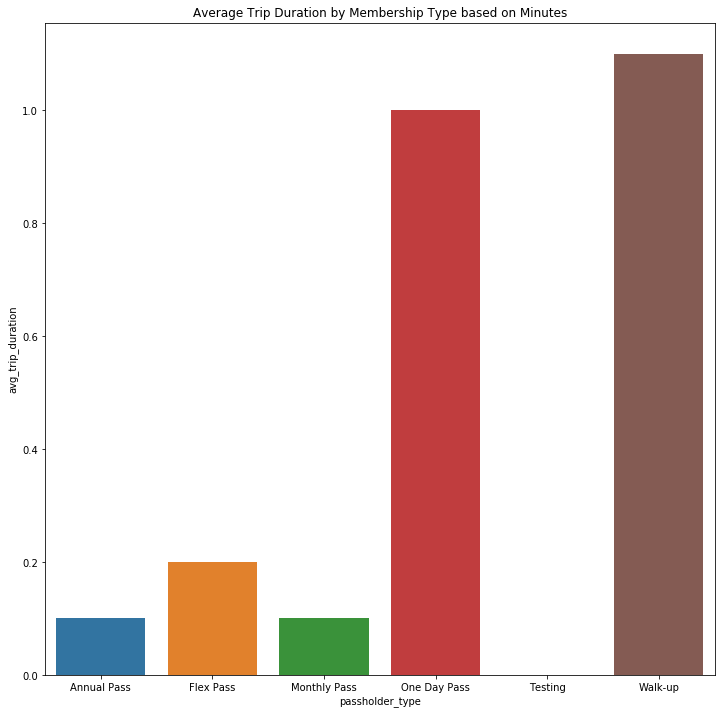

In [23]:
# add minutes column for trip duration
trip_merged['minutes'] = round(trip_merged['duration']/60).astype(int)

# calculate trip duration based on minutes
avg_dur_membership = pd.DataFrame()
avg_dur_membership['avg_trip_duration'] = round(trip_merged.groupby('passholder_type')['minutes'].mean(),1)
avg_dur_membership = avg_dur_membership.reset_index()
avg_dur_membership['passholder_type'] = avg_dur_membership['passholder_type'].astype('object')

# plot the graph
g = sns.barplot('passholder_type', 'avg_trip_duration', data = avg_dur_membership)
plt.Figure(figsize=(20,20))
plt.title("Average Trip Duration by Membership Type based on Minutes")

plt.show(g)

#### 5. Top 5 stations with the most starts (showing # of starts)

We want to check which station should be adequately stuffed based on usage.

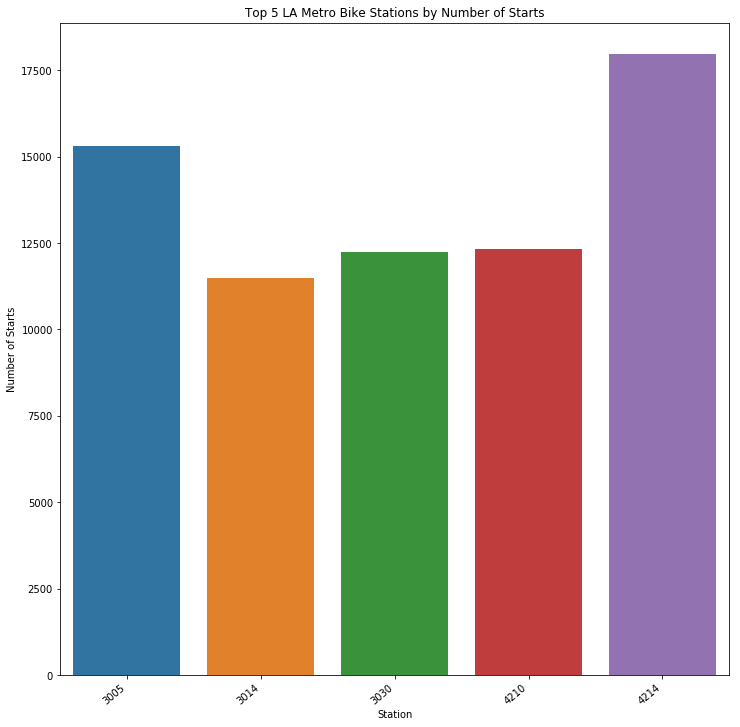

In [24]:
# data for Top 5 Stations visual
top5 = pd.DataFrame()
top5['Station'] = trip_merged['start_station'].value_counts().head().index
top5['Number of Starts']=trip_merged['start_station'].value_counts().head().values
top5['Station'] = top5['Station'].astype('category')
top5['Station'] = top5.Station.cat.remove_unused_categories()

# plot the top 5 stations
sns.barplot('Station', 'Number of Starts', data = top5)
plt.xticks(rotation=40, ha = 'right')
plt.title("Top 5 LA Metro Bike Stations by Number of Starts")
plt.show()

#### 6. Plot of active stations

Geoplotting the locations of active stations. Since we do not have lat-long for the unique stations in the station, we will get the active stations from the station data and lat-long from the trip data.

In [25]:
# get active stations
station_act = pd.DataFrame()
station_act = station[station.Status == 'Active'][['Station_ID']] \
.rename(index=str, columns={'Station_ID': 'station_id'})

# add the lat-long from trip data
# first try the start stations
start_geo = trip_merged[['start_station','start_lat','start_lon']] \
.rename(index=str, columns={'start_station': 'station_id', 'start_lat': 'lat', 'start_lon': 'lon'})

end_geo = trip_merged[['end_station','end_lat','end_lon']] \
.rename(index=str, columns={'end_station': 'station_id', 'end_lat': 'lat', 'end_lon': 'lon'})

station_geo = start_geo.append(end_geo).drop_duplicates().dropna()

#### 7. Most Popular Trip

The intention is to find the most popular trip in the LA bike route so that the promotion is effectively directed.

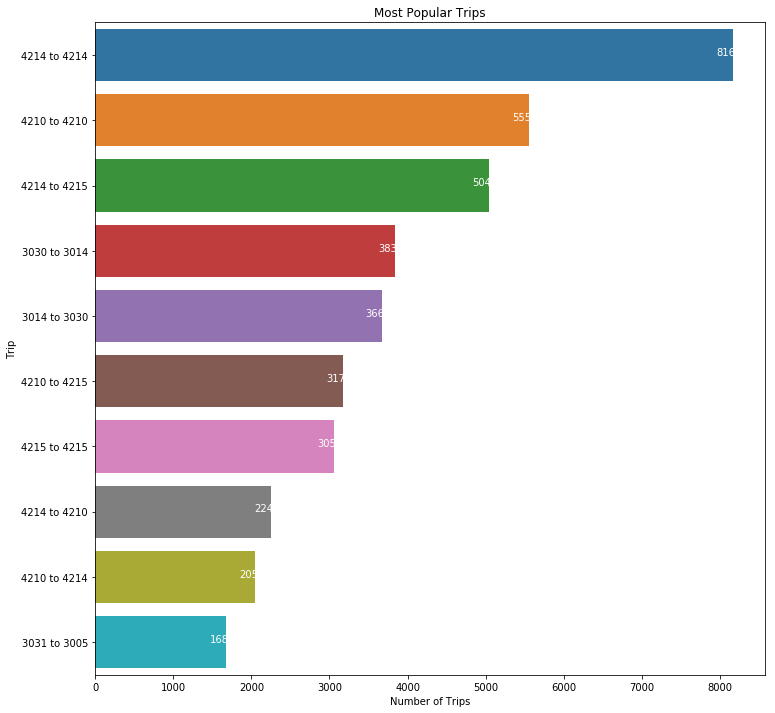

In [26]:
# calculate the number of trips between each stations
trips_df = pd.DataFrame()
trips_df = trip_merged.groupby(['start_station','end_station']).size().reset_index(name = 'Number of Trips')
trips_df = trips_df.sort_values('Number of Trips', ascending = False)
trips_df['Starting Station ID'] = trips_df['start_station'].astype('str')
trips_df['Ending Station ID'] = trips_df['end_station'].astype('str')
trips_df['Trip'] = trips_df['Starting Station ID'] + ' to ' + trips_df['Ending Station ID']
trips_df = trips_df[:10]
trips_df = trips_df.drop(['Starting Station ID', 'Ending Station ID'], axis = 1)
trips_df = trips_df.reset_index()

# find the most popular trips
g = sns.barplot('Number of Trips','Trip', data = trips_df)
plt.title("Most Popular Trips")
for index, row in trips_df.iterrows():
    g.text(row['Number of Trips']-50,index,row['Number of Trips'], 
             color='white', ha="center",fontsize = 10)
plt.show()

#### 8. Bike traffic through the year

Check the trend of trips (trip counts) by summarizing trip counts for each date

In [27]:
countbydates = trip_merged.groupby(['date']).trip_id.count().reset_index(name='counts')
countbydates.head()

,date,counts
0,2018-01-01,781
1,2018-01-02,765
2,2018-01-03,717
3,2018-01-04,736
4,2018-01-05,742


Text(0.5, 1.0, 'Trips throughout the year - Trend analysis')

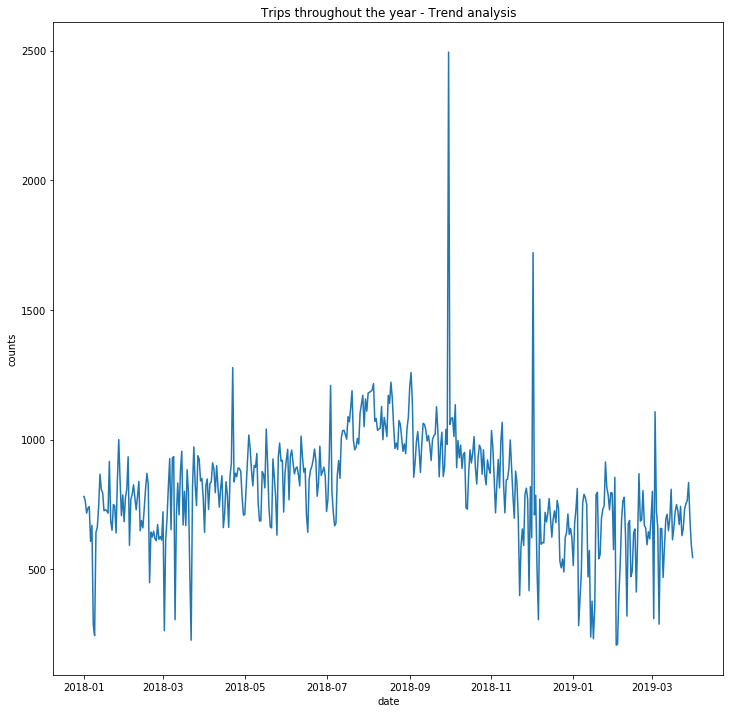

In [28]:
sns.lineplot(x="date", y="counts",
                data=countbydates)

plt.title("Trips throughout the year - Trend analysis")

Looks like there are some interesting peaks around October 2018 and December 2018

#### 9. Exploring trips by dates through scatter plot

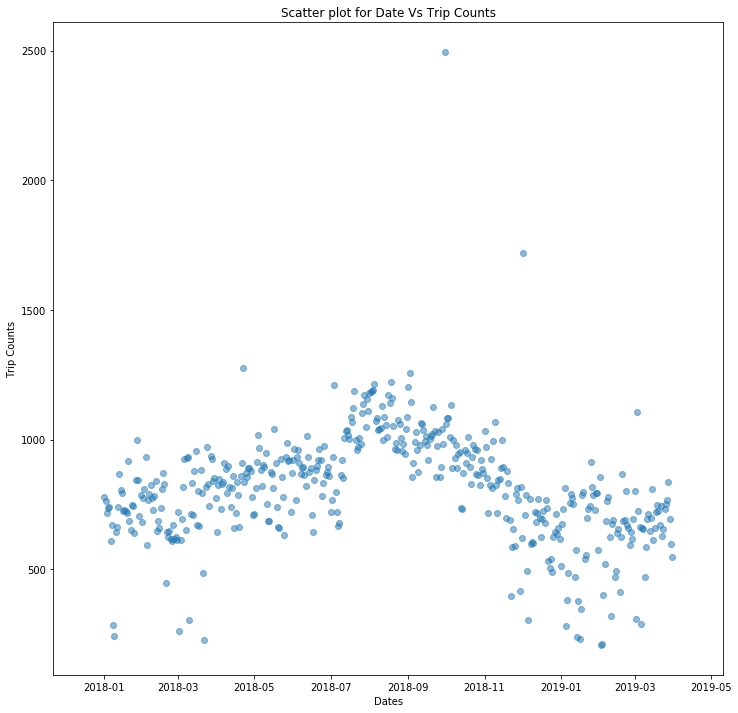

In [29]:
# Plot
plt.scatter(countbydates.date, countbydates.counts,alpha=0.5)
plt.title('Scatter plot for Date Vs Trip Counts')
plt.xlabel('Dates')
plt.ylabel('Trip Counts')
plt.show()

#### 10. Exploring trips interms of weekdays

In [30]:

trip_merged.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'start_region', 'start_status', 'end_region', 'end_status',
       'date', 'tmin', 'tavg', 'tmax', 'minutes'],
      dtype='object')

In [31]:
# derving 'day of week' attribute from date
trip_merged['day_of_week'] = trip_merged['date'].dt.day_name()
trip_merged.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,start_region,start_status,end_region,end_status,date,tmin,tavg,tmax,minutes,day_of_week
0,112536773,7,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
1,112536772,6,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
2,112538689,32,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,1,Tuesday
3,112538688,30,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
4,112538687,28,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday


In [32]:
# summarizing trips with dates and day of weeks
countbywkday = trip_merged.groupby(['date', 'day_of_week']).trip_id.count().reset_index(name='counts')
countbywkday.head()

,date,day_of_week,counts
0,2018-01-01,Monday,781
1,2018-01-02,Tuesday,765
2,2018-01-03,Wednesday,717
3,2018-01-04,Thursday,736
4,2018-01-05,Friday,742


(736664.0, 737180.0)

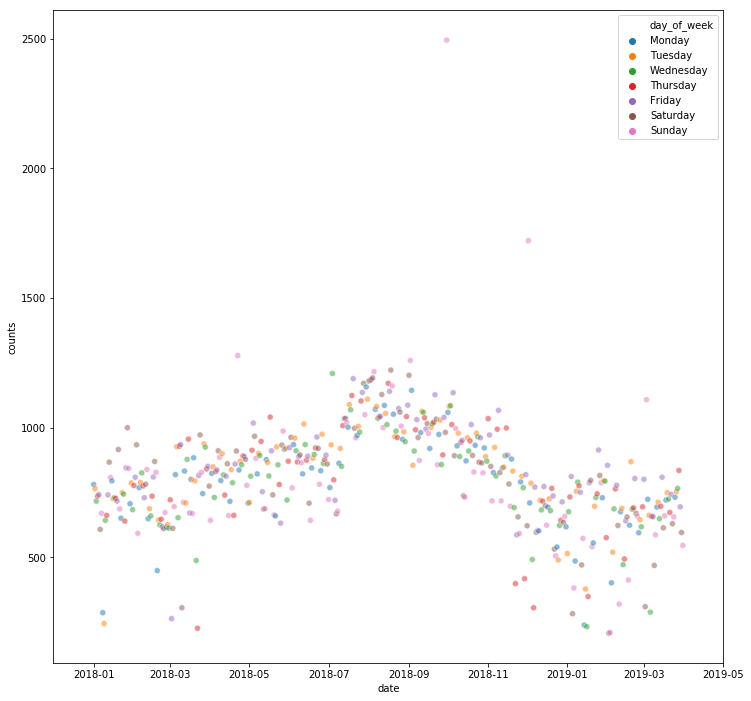

In [33]:
sns.scatterplot(x = countbywkday.date,y = countbywkday.counts, hue = countbywkday.day_of_week, alpha=0.5)

# control x and y limits
plt.xlim('2017-12-01', '2019-05-01')


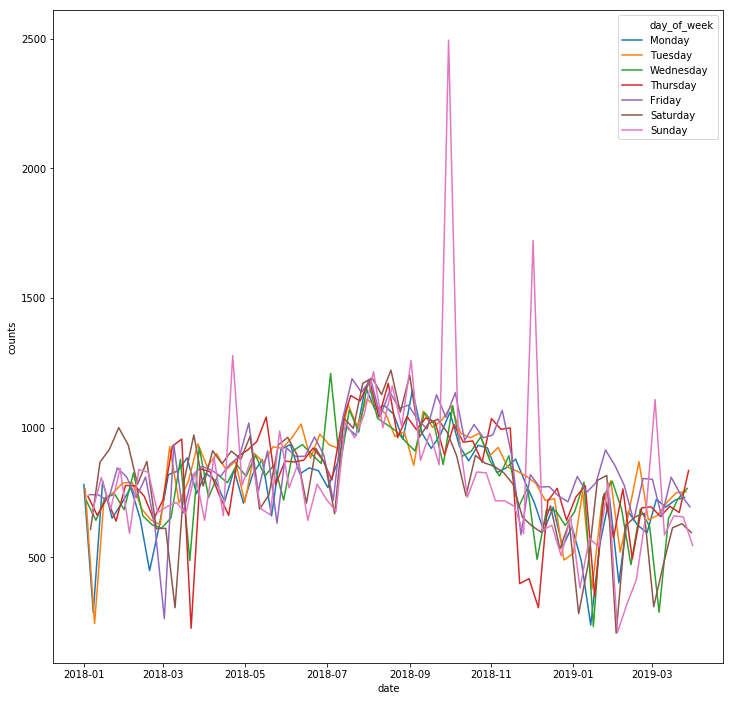

In [34]:
sns.lineplot(x = countbywkday.date,y = countbywkday.counts, hue = countbywkday.day_of_week)

From the above chart, looks the most trips between 2018-01-01 to 2019-03-31 happend on Sundays

In [35]:
pd.get_dummies(trip_merged)

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,end_region_Westside,end_status_Active,end_status_Inactive,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,112536773,7,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,34.052872,-118.247490,3051,34.045422,-118.253517,...,0,1,0,0,0,0,0,0,1,0
1,112536772,6,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,34.052872,-118.247490,3051,34.045422,-118.253517,...,0,1,0,0,0,0,0,0,1,0
2,112538689,32,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,34.051941,-118.243530,3075,34.042110,-118.256187,...,0,1,0,0,0,0,0,0,1,0
3,112538688,30,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,34.051941,-118.243530,3075,34.042110,-118.256187,...,0,1,0,0,0,0,0,0,1,0
4,112538687,28,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,34.051941,-118.243530,3075,34.042110,-118.256187,...,0,1,0,0,0,0,0,0,1,0
5,112538686,28,2019-01-01 00:23:00,2019-01-01 00:51:00,3030,34.051941,-118.243530,3075,34.042110,-118.256187,...,0,1,0,0,0,0,0,0,1,0
6,112538685,27,2019-01-01 00:24:00,2019-01-01 00:51:00,3030,34.051941,-118.243530,3075,34.042110,-118.256187,...,0,1,0,0,0,0,0,0,1,0
7,112537730,7,2019-01-01 00:27:00,2019-01-01 00:34:00,3029,34.048851,-118.246422,3038,34.046822,-118.248352,...,0,1,0,0,0,0,0,0,1,0
8,112538445,19,2019-01-01 00:27:00,2019-01-01 00:46:00,3030,34.051941,-118.243530,3031,34.044701,-118.252441,...,0,1,0,0,0,0,0,0,1,0
9,112537729,6,2019-01-01 00:28:00,2019-01-01 00:34:00,3029,34.048851,-118.246422,3038,34.046822,-118.248352,...,0,1,0,0,0,0,0,0,1,0


In [36]:
trip_merged.shape

(369252, 25)

# Predictive Analytics

# 1) Predictive modelling for predicting usage rate for a given station

### Data Preparation for the model

In [37]:
trip_merged.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'start_region', 'start_status', 'end_region', 'end_status',
       'date', 'tmin', 'tavg', 'tmax', 'minutes', 'day_of_week'],
      dtype='object')

In [38]:
trip_merged.shape

(369252, 25)

In [39]:
trip_merged.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,start_region,start_status,end_region,end_status,date,tmin,tavg,tmax,minutes,day_of_week
0,112536773,7,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
1,112536772,6,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
2,112538689,32,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,1,Tuesday
3,112538688,30,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
4,112538687,28,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday


In [40]:
#outstation_df = unique(trip_merged['start_station', 'date'])

In [41]:
outstation_df = pd.DataFrame()
outstation_df['Station'] = trip_merged['start_station'].value_counts().head().index
outstation_df['Number of Starts']=trip_merged['start_station'].value_counts().head().values

In [42]:
outstation_df.head()

,Station,Number of Starts
0,4214,17978
1,3005,15317
2,4210,12329
3,3030,12240
4,3014,11484


In [43]:
outstation_df = pd.DataFrame()
outstation_df = trip_merged.groupby(['start_station', 'date','day_of_week'])['trip_id'].count().reset_index()
outstation_df.rename(columns = {'trip_id': 'outgoingbikes'}, inplace = True)
outstation_df.head()

,start_station,date,day_of_week,outgoingbikes
0,3000,2018-01-01,Monday,2
1,3000,2018-01-03,Wednesday,1
2,3000,2018-01-11,Thursday,1
3,3000,2018-01-13,Saturday,1
4,3000,2018-01-14,Sunday,4


In [44]:
instation_df = pd.DataFrame()
instation_df = trip_merged.groupby(['end_station', 'date','day_of_week'])['trip_id'].count().reset_index()
instation_df.rename(columns = {'trip_id': 'incomingbikes'}, inplace = True)
instation_df.head()

,end_station,date,day_of_week,incomingbikes
0,3000,2018-01-01,Monday,24
1,3000,2018-01-02,Tuesday,10
2,3000,2018-01-03,Wednesday,15
3,3000,2018-01-04,Thursday,13
4,3000,2018-01-05,Friday,10


In [45]:
#trip_merged.groupby(['date','start_station'])['trip_id'].count().unstack()

In [46]:
station.columns
station.head()

,Station_ID,Station_Name,Go_live_date,Region,Status
0,3000,Virtual Station,7/7/2016,NaN,Active
1,3005,7th & Flower,7/7/2016,DTLA,Active
2,3006,Olive & 8th,7/7/2016,DTLA,Active
3,3007,5th & Grand,7/7/2016,DTLA,Active
4,3008,Figueroa & 9th,7/7/2016,DTLA,Active


In [47]:
# unique list of stations
len(outstation_df.start_station.unique())

183

In [48]:
# unique list of stations
len(instation_df.end_station.unique())
#instation_df.end_station.value_counts()

181

In [49]:
# unique list of stations
len(station.Station_ID.unique())

188

In [50]:
# merging all data sets for modelling
print(instation_df.shape)
print(outstation_df.shape)

(41912, 4)
(41865, 4)


In [51]:
merge1df = pd.merge(station,outstation_df, left_on = 'Station_ID', right_on='start_station', how = 'outer' )
merge1df.shape

(41871, 9)

In [52]:
# unique list of stations
len(merge1df.Station_ID.unique())

189

In [53]:
print(len(merge1df[merge1df.Station_ID.isnull()]))

11


In [54]:
merge1df[merge1df.Station_ID.isnull()]

,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes
41860,NaN,NaN,NaN,NaN,NaN,4108.0,2018-02-01,Thursday,4.0
41861,NaN,NaN,NaN,NaN,NaN,4108.0,2018-02-12,Monday,1.0
41862,NaN,NaN,NaN,NaN,NaN,4108.0,2018-03-05,Monday,6.0
41863,NaN,NaN,NaN,NaN,NaN,4108.0,2018-03-12,Monday,1.0
41864,NaN,NaN,NaN,NaN,NaN,4108.0,2018-03-14,Wednesday,1.0
41865,NaN,NaN,NaN,NaN,NaN,4108.0,2018-05-31,Thursday,1.0
41866,NaN,NaN,NaN,NaN,NaN,4108.0,2018-06-05,Tuesday,1.0
41867,NaN,NaN,NaN,NaN,NaN,4108.0,2018-06-19,Tuesday,1.0
41868,NaN,NaN,NaN,NaN,NaN,4108.0,2018-09-24,Monday,1.0
41869,NaN,NaN,NaN,NaN,NaN,4108.0,2018-09-29,Saturday,36.0


In [55]:
# looks like station 4108 is not present in station data. So, lets add it
merge1df.Station_ID.fillna(merge1df.start_station, inplace = True)

In [56]:
print(len(merge1df[merge1df.Station_ID.isnull()]))
merge1df[merge1df.Station_ID.isnull()]

0


,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes


In [57]:
print(len(merge1df.start_station.unique()))
print(len(merge1df[merge1df.start_station.isnull()]))

184
6


In [58]:
merge1df[merge1df.start_station.isnull()]

,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes
4850,3021.0,3rd & Rose,7/7/2016,DTLA,Inactive,NaN,NaT,NaN,NaN
18128,3059.0,11th & Santee,7/7/2016,DTLA,Inactive,NaN,NaT,NaN,NaN
18129,3060.0,Pico & Maple,7/7/2016,DTLA,Inactive,NaN,NaT,NaN,NaN
31101,4164.0,Allen Station,7/14/2017,Pasadena,Inactive,NaN,NaT,NaN,NaN
33266,4194.0,Union Station East,7/25/2017,DTLA,Inactive,NaN,NaT,NaN,NaN
38405,4217.0,Venice & Abbot Kinney,7/7/2017,Westside,Inactive,NaN,NaT,NaN,NaN


In [59]:
merge1df.head()

,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes
0,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-01,Monday,2.0
1,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-03,Wednesday,1.0
2,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-11,Thursday,1.0
3,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-13,Saturday,1.0
4,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-14,Sunday,4.0


In [60]:
#merge1df.rename(columns = {'date':'date1'}, inplace = True)
#merge1df.columns

In [61]:
merge2df = pd.merge(merge1df, instation_df, left_on = ['Station_ID','date','day_of_week'], 
                                           right_on=['end_station', 'date','day_of_week'], how = 'outer' )
merge2df.shape

(44177, 11)

In [62]:
merge2df.columns

Index(['Station_ID', 'Station_Name', 'Go_live_date', 'Region ', 'Status',
       'start_station', 'date', 'day_of_week', 'outgoingbikes', 'end_station',
       'incomingbikes'],
      dtype='object')

In [63]:
merge2df.head()

,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes,end_station,incomingbikes
0,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-01,Monday,2.0,3000.0,24.0
1,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-03,Wednesday,1.0,3000.0,15.0
2,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-11,Thursday,1.0,3000.0,8.0
3,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-13,Saturday,1.0,3000.0,8.0
4,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-14,Sunday,4.0,3000.0,20.0


In [64]:
# Check for unmatched stations (end stations)
print(len(merge2df[merge2df.Station_ID.isnull()]))

2306


In [65]:
merge2df[merge2df.Station_ID.isnull()].head()

,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes,end_station,incomingbikes
41871,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-02,Tuesday,NaN,3000.0,10.0
41872,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-04,Thursday,NaN,3000.0,13.0
41873,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-05,Friday,NaN,3000.0,10.0
41874,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-06,Saturday,NaN,3000.0,8.0
41875,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-07,Sunday,NaN,3000.0,8.0


In [66]:
# looks like stations and date combination records doesnt exist, lets add those to the station_ID
merge2df.Station_ID.fillna(merge2df.end_station, inplace = True)

In [67]:
# Now check for unmatched stations (end stations)
print(len(merge2df[merge2df.Station_ID.isnull()]))

0


In [68]:
weather.columns

Index(['date', 'tmin', 'tavg', 'tmax'], dtype='object')

In [69]:
# joining weather data
merge3df = pd.merge(merge2df,weather, left_on = ['date'], right_on = ['date'] , how = 'outer')
merge3df.shape

(44278, 14)

In [70]:
merge3df.head()

,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes,end_station,incomingbikes,tmin,tavg,tmax
0,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-01,Monday,2.0,3000.0,24.0,48.535714,58.910714,70.392857
1,3005.0,7th & Flower,7/7/2016,DTLA,Active,3005.0,2018-01-01,Monday,13.0,3005.0,11.0,48.535714,58.910714,70.392857
2,3006.0,Olive & 8th,7/7/2016,DTLA,Active,3006.0,2018-01-01,Monday,15.0,3006.0,11.0,48.535714,58.910714,70.392857
3,3007.0,5th & Grand,7/7/2016,DTLA,Active,3007.0,2018-01-01,Monday,10.0,3007.0,6.0,48.535714,58.910714,70.392857
4,3008.0,Figueroa & 9th,7/7/2016,DTLA,Active,3008.0,2018-01-01,Monday,2.0,3008.0,10.0,48.535714,58.910714,70.392857


In [71]:
summarydf = merge3df.copy()
summarydf.to_excel("data/summarydfv1.xlsx")
summarydf = summarydf.drop(['start_station', 'end_station'], axis=1) #, inplace = True)

summarydf['year'] = pd.DatetimeIndex(summarydf['date']).year
summarydf['month'] = pd.DatetimeIndex(summarydf['date']).month

summarydf.head()

,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month
0,3000.0,Virtual Station,7/7/2016,NaN,Active,2018-01-01,Monday,2.0,24.0,48.535714,58.910714,70.392857,2018.0,1.0
1,3005.0,7th & Flower,7/7/2016,DTLA,Active,2018-01-01,Monday,13.0,11.0,48.535714,58.910714,70.392857,2018.0,1.0
2,3006.0,Olive & 8th,7/7/2016,DTLA,Active,2018-01-01,Monday,15.0,11.0,48.535714,58.910714,70.392857,2018.0,1.0
3,3007.0,5th & Grand,7/7/2016,DTLA,Active,2018-01-01,Monday,10.0,6.0,48.535714,58.910714,70.392857,2018.0,1.0
4,3008.0,Figueroa & 9th,7/7/2016,DTLA,Active,2018-01-01,Monday,2.0,10.0,48.535714,58.910714,70.392857,2018.0,1.0


In [72]:
summarydf.shape

(44278, 14)

In [73]:
# Check for how many nulls station id are there
print(len(summarydf[summarydf.Station_ID.isnull()]))

101


In [74]:
# Check for  nulls station id in detail
summarydf[summarydf.Station_ID.isnull()]

,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month
44177,NaN,NaN,NaN,NaN,NaN,2019-04-01,NaN,NaN,NaN,57.142857,68.339286,80.535714,2019.0,4.0
44178,NaN,NaN,NaN,NaN,NaN,2019-04-02,NaN,NaN,NaN,52.500000,60.857143,69.500000,2019.0,4.0
44179,NaN,NaN,NaN,NaN,NaN,2019-04-03,NaN,NaN,NaN,51.214286,57.553571,64.892857,2019.0,4.0
44180,NaN,NaN,NaN,NaN,NaN,2019-04-04,NaN,NaN,NaN,50.857143,56.464286,64.214286,2019.0,4.0
44181,NaN,NaN,NaN,NaN,NaN,2019-04-05,NaN,NaN,NaN,49.607143,56.303571,63.714286,2019.0,4.0
44182,NaN,NaN,NaN,NaN,NaN,2019-04-06,NaN,NaN,NaN,51.250000,59.875000,69.142857,2019.0,4.0
44183,NaN,NaN,NaN,NaN,NaN,2019-04-07,NaN,NaN,NaN,53.500000,66.410714,79.928571,2019.0,4.0
44184,NaN,NaN,NaN,NaN,NaN,2019-04-08,NaN,NaN,NaN,60.000000,71.267857,84.392857,2019.0,4.0
44185,NaN,NaN,NaN,NaN,NaN,2019-04-09,NaN,NaN,NaN,55.464286,65.785714,75.892857,2019.0,4.0
44186,NaN,NaN,NaN,NaN,NaN,2019-04-10,NaN,NaN,NaN,53.821429,62.839286,72.464286,2019.0,4.0


In [75]:
# we can drop these records if there are no bikes trips on such dates
summarydf = summarydf.dropna(axis=0, subset=['Station_ID'])

In [76]:
# Check for  nulls station id
print(len(summarydf[summarydf.Station_ID.isnull()]))

0


In [77]:
summarydf.shape

(44177, 14)

### Consdering impact of hoildays of bike rentals

In [78]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidaydf = pd.DataFrame()
holidaydf['holiday_date'] = cal.holidays('2018', '2020')
holidaydf['holidayflag'] = 1
print(type(holidaydf))

<class 'pandas.core.frame.DataFrame'>


In [79]:
holidaydf

,holiday_date,holidayflag
0,2018-01-01,1
1,2018-01-15,1
2,2018-02-19,1
3,2018-05-28,1
4,2018-07-04,1
5,2018-09-03,1
6,2018-10-08,1
7,2018-11-12,1
8,2018-11-22,1
9,2018-12-25,1


In [80]:
# merging holiday calendar and summary data set
summarydf = pd.merge(summarydf,holidaydf, left_on = ['date'], right_on = ['holiday_date'] , how = 'outer')
summarydf.head()

,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holiday_date,holidayflag
0,3000.0,Virtual Station,7/7/2016,NaN,Active,2018-01-01,Monday,2.0,24.0,48.535714,58.910714,70.392857,2018.0,1.0,2018-01-01,1.0
1,3005.0,7th & Flower,7/7/2016,DTLA,Active,2018-01-01,Monday,13.0,11.0,48.535714,58.910714,70.392857,2018.0,1.0,2018-01-01,1.0
2,3006.0,Olive & 8th,7/7/2016,DTLA,Active,2018-01-01,Monday,15.0,11.0,48.535714,58.910714,70.392857,2018.0,1.0,2018-01-01,1.0
3,3007.0,5th & Grand,7/7/2016,DTLA,Active,2018-01-01,Monday,10.0,6.0,48.535714,58.910714,70.392857,2018.0,1.0,2018-01-01,1.0
4,3008.0,Figueroa & 9th,7/7/2016,DTLA,Active,2018-01-01,Monday,2.0,10.0,48.535714,58.910714,70.392857,2018.0,1.0,2018-01-01,1.0


In [81]:
summarydf.shape

(44185, 16)

In [82]:
# Filling 0's for NaN values - representing not a holiday on that day
summarydf['holidayflag'].fillna(0, inplace=True)


In [83]:
summarydf[summarydf['holidayflag'] ==0].head()

,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holiday_date,holidayflag
102,3000.0,Virtual Station,7/7/2016,NaN,Active,2018-01-03,Wednesday,1.0,15.0,54.0,63.035714,72.142857,2018.0,1.0,NaT,0.0
103,3005.0,7th & Flower,7/7/2016,DTLA,Active,2018-01-03,Wednesday,22.0,26.0,54.0,63.035714,72.142857,2018.0,1.0,NaT,0.0
104,3006.0,Olive & 8th,7/7/2016,DTLA,Active,2018-01-03,Wednesday,10.0,8.0,54.0,63.035714,72.142857,2018.0,1.0,NaT,0.0
105,3007.0,5th & Grand,7/7/2016,DTLA,Active,2018-01-03,Wednesday,15.0,12.0,54.0,63.035714,72.142857,2018.0,1.0,NaT,0.0
106,3008.0,Figueroa & 9th,7/7/2016,DTLA,Active,2018-01-03,Wednesday,6.0,11.0,54.0,63.035714,72.142857,2018.0,1.0,NaT,0.0


In [84]:
# check number of records on holidays and non holidays
summarydf.groupby(['holidayflag'])['Station_ID'].count()

holidayflag
0.0    42983
1.0     1194
Name: Station_ID, dtype: int64

In [85]:
# converting saturdays and sundays into holidays as well
summarydf.loc[summarydf['day_of_week'] == 'Sunday', 'holidayflag'] = 1
summarydf.loc[summarydf['day_of_week'] == 'Saturday', 'holidayflag'] = 1

In [86]:
# check number of records on holidays including saturdays and sundays and non - holidays
summarydf.groupby(['holidayflag'])['Station_ID'].count()

holidayflag
0.0    30314
1.0    13863
Name: Station_ID, dtype: int64

In [87]:
summarydf.describe()

,Station_ID,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag
count,44177.000000,41865.000000,41912.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44185.000000
mean,3515.717523,8.820064,8.810174,54.260292,63.366169,73.422035,2018.180616,5.469290,0.313930
std,568.202044,9.919497,10.547811,8.349669,9.128369,10.529879,0.384704,3.445199,0.464094
min,3000.000000,1.000000,1.000000,36.321429,44.517857,52.370370,2018.000000,1.000000,0.000000
25%,3034.000000,3.000000,3.000000,48.535714,57.000000,65.321429,2018.000000,2.000000,0.000000
50%,3068.000000,6.000000,6.000000,53.142857,62.339286,73.285714,2018.000000,5.000000,0.000000
75%,4167.000000,12.000000,11.000000,60.214286,70.351852,81.629630,2018.000000,8.000000,1.000000
max,4385.000000,534.000000,787.000000,77.185185,89.555556,106.740741,2019.000000,12.000000,1.000000


In [88]:
summarydf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44185 entries, 0 to 44184
Data columns (total 16 columns):
Station_ID       44177 non-null float64
Station_Name     41860 non-null object
Go_live_date     41860 non-null object
Region           41777 non-null object
Status           41860 non-null object
date             44171 non-null datetime64[ns]
day_of_week      44171 non-null object
outgoingbikes    41865 non-null float64
incomingbikes    41912 non-null float64
tmin             44171 non-null float64
tavg             44171 non-null float64
tmax             44171 non-null float64
year             44171 non-null float64
month            44171 non-null float64
holiday_date     1202 non-null datetime64[ns]
holidayflag      44185 non-null float64
dtypes: datetime64[ns](2), float64(9), object(5)
memory usage: 5.7+ MB


In [89]:
# checking for null records
summarydf[summarydf['Station_ID'].isna()]

,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holiday_date,holidayflag
44177,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-27,1.0
44178,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-04,1.0
44179,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-02,1.0
44180,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-14,1.0
44181,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-11,1.0
44182,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-28,1.0
44183,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-25,1.0
44184,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-01,1.0


In [90]:
# deleting the above null records as we dont have any bike trip details for those dates
summarydf = summarydf.dropna(axis=0, subset=['Station_ID'])

In [91]:
summarydf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44177 entries, 0 to 44176
Data columns (total 16 columns):
Station_ID       44177 non-null float64
Station_Name     41860 non-null object
Go_live_date     41860 non-null object
Region           41777 non-null object
Status           41860 non-null object
date             44171 non-null datetime64[ns]
day_of_week      44171 non-null object
outgoingbikes    41865 non-null float64
incomingbikes    41912 non-null float64
tmin             44171 non-null float64
tavg             44171 non-null float64
tmax             44171 non-null float64
year             44171 non-null float64
month            44171 non-null float64
holiday_date     1194 non-null datetime64[ns]
holidayflag      44177 non-null float64
dtypes: datetime64[ns](2), float64(9), object(5)
memory usage: 5.7+ MB


In [92]:
# checking for null records
print(len(summarydf[summarydf['date'].isna()]))
summarydf[summarydf['date'].isna()]

6


,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holiday_date,holidayflag
44171,3021.0,3rd & Rose,7/7/2016,DTLA,Inactive,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44172,3059.0,11th & Santee,7/7/2016,DTLA,Inactive,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44173,3060.0,Pico & Maple,7/7/2016,DTLA,Inactive,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44174,4164.0,Allen Station,7/14/2017,Pasadena,Inactive,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44175,4194.0,Union Station East,7/25/2017,DTLA,Inactive,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44176,4217.0,Venice & Abbot Kinney,7/7/2017,Westside,Inactive,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0


In [93]:
# dropping the above records
summarydf = summarydf.dropna(axis=0, subset=['date'])
# checking for null records
print(len(summarydf[summarydf['date'].isna()]))

0


In [94]:
# StationId is in float format, converting that ID into categorical variables
summarydf['Station_ID'] = summarydf['Station_ID'].astype(dtype=np.int64)
summarydf['Station_ID'] = summarydf['Station_ID'].astype('category')

summarydf['year'] = summarydf['year'].astype(dtype = np.int64)
summarydf['month'] = summarydf['month'].astype(dtype = np.int64)
summarydf.head()

,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holiday_date,holidayflag
0,3000,Virtual Station,7/7/2016,NaN,Active,2018-01-01,Monday,2.0,24.0,48.535714,58.910714,70.392857,2018,1,2018-01-01,1.0
1,3005,7th & Flower,7/7/2016,DTLA,Active,2018-01-01,Monday,13.0,11.0,48.535714,58.910714,70.392857,2018,1,2018-01-01,1.0
2,3006,Olive & 8th,7/7/2016,DTLA,Active,2018-01-01,Monday,15.0,11.0,48.535714,58.910714,70.392857,2018,1,2018-01-01,1.0
3,3007,5th & Grand,7/7/2016,DTLA,Active,2018-01-01,Monday,10.0,6.0,48.535714,58.910714,70.392857,2018,1,2018-01-01,1.0
4,3008,Figueroa & 9th,7/7/2016,DTLA,Active,2018-01-01,Monday,2.0,10.0,48.535714,58.910714,70.392857,2018,1,2018-01-01,1.0


In [95]:
#taking backup of dataframe
summarydfcopy = summarydf.copy()
summarydf.shape

(44171, 16)

## Data Pre-processing

### Feature Engineering

In [96]:
summarydf = summarydfcopy.copy()

In [97]:
summarydf.columns

Index(['Station_ID', 'Station_Name', 'Go_live_date', 'Region ', 'Status',
       'date', 'day_of_week', 'outgoingbikes', 'incomingbikes', 'tmin', 'tavg',
       'tmax', 'year', 'month', 'holiday_date', 'holidayflag'],
      dtype='object')

In [98]:
#Removing unnecessary attributes
summarydf = summarydf.drop(['Station_Name','Go_live_date','Region ', 'date', 'holiday_date'] , axis = 1 )
summarydf.head()

,Station_ID,Status,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag
0,3000,Active,Monday,2.0,24.0,48.535714,58.910714,70.392857,2018,1,1.0
1,3005,Active,Monday,13.0,11.0,48.535714,58.910714,70.392857,2018,1,1.0
2,3006,Active,Monday,15.0,11.0,48.535714,58.910714,70.392857,2018,1,1.0
3,3007,Active,Monday,10.0,6.0,48.535714,58.910714,70.392857,2018,1,1.0
4,3008,Active,Monday,2.0,10.0,48.535714,58.910714,70.392857,2018,1,1.0


In [99]:
#checking for nulls in temperature data
print(len(summarydf[summarydf['tavg'].isna()]))

0


In [100]:
summarydf[summarydf['tavg'].isna()]

,Station_ID,Status,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag


In [101]:
# dropping the above null records as there no trips associated with those stations on those days
summarydf = summarydf.dropna(axis=0, subset=['tavg'])

#checking for nulls in temperature data after deleting rows to confirm
print(len(summarydf[summarydf['tavg'].isna()]))

0


In [102]:
summarydf['totaltrips'] =  summarydf['outgoingbikes'] + summarydf['incomingbikes']

#checking for nulls in temperature data after deleting rows to confirm
print(len(summarydf[summarydf['totaltrips'].isna()]))

# dropping the above null records as there no trips associated with those stations on those days
summarydf = summarydf.dropna(axis=0, subset=['totaltrips'])
summarydf.head()

4565


,Station_ID,Status,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag,totaltrips
0,3000,Active,Monday,2.0,24.0,48.535714,58.910714,70.392857,2018,1,1.0,26.0
1,3005,Active,Monday,13.0,11.0,48.535714,58.910714,70.392857,2018,1,1.0,24.0
2,3006,Active,Monday,15.0,11.0,48.535714,58.910714,70.392857,2018,1,1.0,26.0
3,3007,Active,Monday,10.0,6.0,48.535714,58.910714,70.392857,2018,1,1.0,16.0
4,3008,Active,Monday,2.0,10.0,48.535714,58.910714,70.392857,2018,1,1.0,12.0


In [103]:
#checking for nulls in temperature data after deleting rows to confirm
print(len(summarydf[summarydf['totaltrips'].isna()]))

0


In [104]:
#checking for nulls in temperature data after deleting rows to confirm
print(len(summarydf[summarydf['totaltrips'] < 1]))

0


In [105]:
# converting holiday flag into integer
summarydf['holidayflag'] = summarydf['holidayflag'].astype(dtype = np.int64)

In [106]:
summarydf.to_excel("data/summary.xlsx")

In [107]:
# Create dummy variables for categorical variables - Station_Id, day of week and status
summarydf_features = pd.DataFrame()
summarydf_features = pd.get_dummies(summarydf)
summarydf_features.head()

,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag,totaltrips,Station_ID_3000,...,Station_ID_4385,Status_Active,Status_Inactive,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,2.0,24.0,48.535714,58.910714,70.392857,2018,1,1,26.0,1,...,0,1,0,0,1,0,0,0,0,0
1,13.0,11.0,48.535714,58.910714,70.392857,2018,1,1,24.0,0,...,0,1,0,0,1,0,0,0,0,0
2,15.0,11.0,48.535714,58.910714,70.392857,2018,1,1,26.0,0,...,0,1,0,0,1,0,0,0,0,0
3,10.0,6.0,48.535714,58.910714,70.392857,2018,1,1,16.0,0,...,0,1,0,0,1,0,0,0,0,0
4,2.0,10.0,48.535714,58.910714,70.392857,2018,1,1,12.0,0,...,0,1,0,0,1,0,0,0,0,0


In [108]:
summarydf_features.columns

Index(['outgoingbikes', 'incomingbikes', 'tmin', 'tavg', 'tmax', 'year',
       'month', 'holidayflag', 'totaltrips', 'Station_ID_3000',
       ...
       'Station_ID_4385', 'Status_Active', 'Status_Inactive',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday'],
      dtype='object', length=201)

In [109]:
# Removing one category out of each categorical dummy variable
summarydf_features = summarydf_features.drop(['Station_ID_4385','Status_Inactive','day_of_week_Tuesday','totaltrips'] , axis = 1 )
summarydf_features.head()

,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag,Station_ID_3000,Station_ID_3005,...,Station_ID_4380,Station_ID_4381,Station_ID_4382,Status_Active,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Wednesday
0,2.0,24.0,48.535714,58.910714,70.392857,2018,1,1,1,0,...,0,0,0,1,0,1,0,0,0,0
1,13.0,11.0,48.535714,58.910714,70.392857,2018,1,1,0,1,...,0,0,0,1,0,1,0,0,0,0
2,15.0,11.0,48.535714,58.910714,70.392857,2018,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0
3,10.0,6.0,48.535714,58.910714,70.392857,2018,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0
4,2.0,10.0,48.535714,58.910714,70.392857,2018,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0


## Building Model

#### We are trying to build a model to predict the number of bike trips from that station and number of trips ending at that station. So we have 2 dependant variables and rest are independant variables.

### Model Training and Testing

In [120]:
# Import required modules for modelling
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import mean_absolute_error # Mean Absolute Error
from sklearn.metrics import mean_squared_error # Mean Squared Error
from sklearn.metrics import r2_score #R² Score

import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
# checking Nans in outgoingbikes columns
print(len(summarydf_features[summarydf_features['outgoingbikes'].isna()]))

0


In [122]:
# checking Nans in incomingbikes columns
print(len(summarydf_features[summarydf_features['incomingbikes'].isna()]))

0


In [123]:
# creating 2 data sets for 2 dependant variables
summarydf_features1 = summarydf_features.dropna(axis=0, subset=['outgoingbikes'])
summarydf_features2 = summarydf_features.dropna(axis=0, subset=['incomingbikes'])

In [124]:
print(len(summarydf_features1))
print(len(summarydf_features2))

39606
39606


In [125]:
# Defining independant variables
features1 = summarydf_features1.iloc[ : ,2:200]
features1.head()

,tmin,tavg,tmax,year,month,holidayflag,Station_ID_3000,Station_ID_3005,Station_ID_3006,Station_ID_3007,...,Station_ID_4380,Station_ID_4381,Station_ID_4382,Status_Active,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Wednesday
0,48.535714,58.910714,70.392857,2018,1,1,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,48.535714,58.910714,70.392857,2018,1,1,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
2,48.535714,58.910714,70.392857,2018,1,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,48.535714,58.910714,70.392857,2018,1,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
4,48.535714,58.910714,70.392857,2018,1,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [126]:
# Defining targets

target1 = summarydf_features1['outgoingbikes'] # Trips that started from that station

In [127]:
# ensuring lenghts of the features and targets
print(len(features1))
print(len(target1))


39606
39606


In [128]:
# splitting data into train (75%) and test (25%)
# for first dependant variable - target1
X1_train, X1_test, y1_train, y1_test = train_test_split(features1, target1, test_size = 0.25, random_state = 0)


In [129]:
# get list of columns having NaN values
X1_train.loc[ : , X1_train.isna().any()]

""
22634
29030
4246
10208
6709
18575
25856
20629
21493
29253


In [130]:
# get list of columns having NaN values
print(len(y1_train.isna()))

29704


#### Feature Scaling

In [131]:
# Feature Scaling
sc_x = StandardScaler()
X1_train_std = sc_x.fit_transform(X1_train)
X1_test_std = sc_x.transform(X1_test)

sc_y = StandardScaler()
y1_train_std = sc_y.fit_transform(y1_train[:, np.newaxis]).flatten()
y1_test_std = sc_y.fit_transform(y1_test[:, np.newaxis]).flatten()
#(y1_train.reshape(-1, 1) )


#### Since the variables are not linear in nature and the predicting variables are continuous variables, we choose to select non- linear regression analysis. 

### Implementing Decision Tree Regressor

#### Fitting Model

In [132]:
# Fitting Decision Tree Regression to the dataset

from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
dtmodel = regressor.fit(X1_train, y1_train)

# Predicting results for training data set
y1_pred_train = regressor.predict(X1_train)

# Predicting results for test data
y1_pred_test = regressor.predict(X1_test)

residuals_dt_train = y1_train - y1_pred_train # actual training value - predicted value for training data set
residuals_dt_test = y1_test - y1_pred_test # actual test value - predicted value for testing data set

#### Model Evaluation on Training Data

In [133]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error is : ", mean_absolute_error(y1_train, y1_pred_train))

#Mean Squared Error
from sklearn.metrics import mean_squared_error
print("Mean Squared Error : ", mean_squared_error(y1_train, y1_pred_train))

#R² Score
from sklearn.metrics import r2_score
print("R-square value : ", r2_score(y1_train, y1_pred_train))

Mean Absolute Error is :  0.0
Mean Squared Error :  0.0
R-square value :  1.0


#### Model Evaluation on Training Data

In [134]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error is : ", mean_absolute_error(y1_test, y1_pred_test))

#Mean Squared Error
from sklearn.metrics import mean_squared_error
print("Mean Squared Error : ", mean_squared_error(y1_test, y1_pred_test))

#R² Score
from sklearn.metrics import r2_score
print("R-square value : ", r2_score(y1_test, y1_pred_test))

Mean Absolute Error is :  4.278630579680873
Mean Squared Error :  81.57856998586144
R-square value :  0.14232187678190478


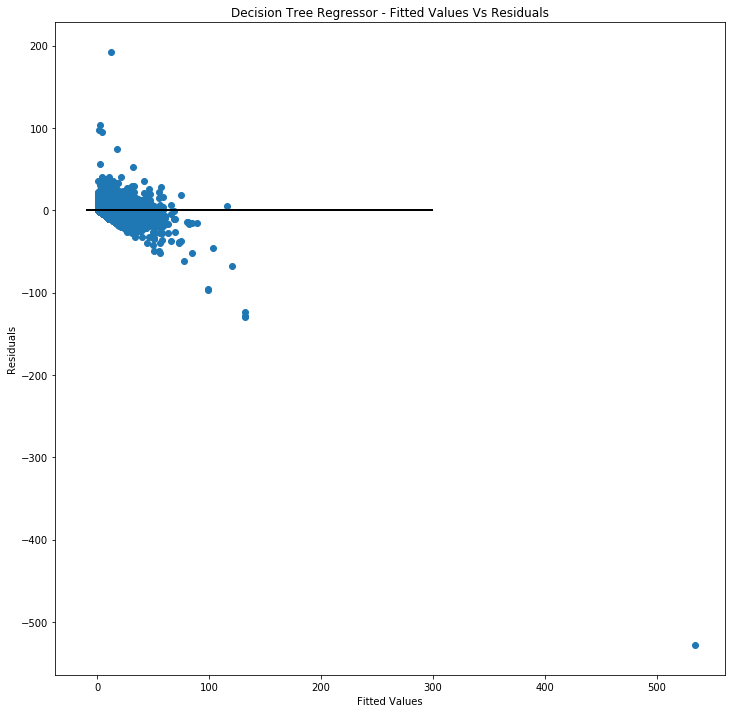

In [135]:
plt.scatter(y1_pred_test,residuals_dt_test)
plt.hlines(y=0, xmin=-10, xmax=300, color='black', lw=2)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Decision Tree Regressor - Fitted Values Vs Residuals")
plt.show()


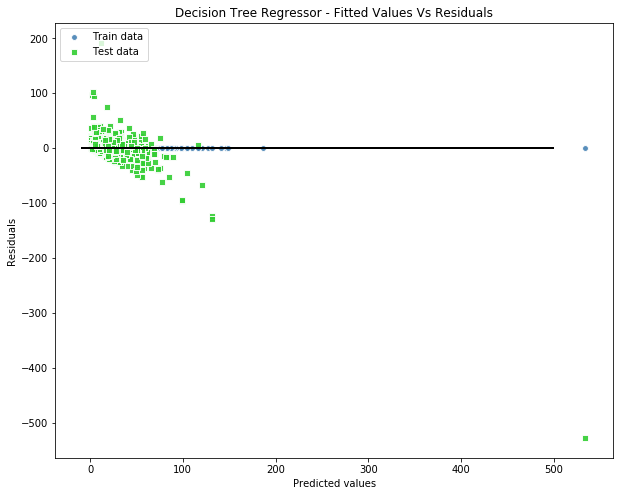

In [136]:
# plotting residuals to see the error pattern

plt.figure(figsize = (10,8))

plt.scatter(y1_pred_train,residuals_dt_train,
               c='steelblue',
                edgecolor='white',
                marker='o',
                s=35,
                alpha=0.9,
                label='Train data')


plt.scatter(y1_pred_test,residuals_dt_test,
                c='limegreen',
                edgecolor='white',
                marker='s',
                s=35,
                alpha=0.9,
                label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title("Decision Tree Regressor - Fitted Values Vs Residuals")
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=500, lw=2, color='black')
#plt.xlim([-10, 50])
plt.show()

#### Decision Tree Regressor Evaluation:

As the errors are randomly distributed and do not see a pattern behind errors, decision tree algorithms seems to explain the variance in the model.

###  Implementing Random Forest Regressor

In [137]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000,
                                    criterion='mse',
                                    random_state=1,
                                    n_jobs=-1)


rfmodel = forest.fit(X1_train, y1_train)

# Predicting a new result for test data 
y1_pred_train_rf = forest.predict(X1_train)


# Predicting a new result for test data 
y1_pred_test_rf = forest.predict(X1_test)

#### Evaluating Random Forrest Regressor on training data set

In [138]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error is : ", mean_absolute_error(y1_train, y1_pred_train_rf))

#Mean Squared Error
from sklearn.metrics import mean_squared_error
print("Mean Squared Error : ", mean_squared_error(y1_train, y1_pred_train_rf))

#R² Score
from sklearn.metrics import r2_score
print("R-square value : ", r2_score(y1_train, y1_pred_train_rf))

Mean Absolute Error is :  1.1931545246431456
Mean Squared Error :  5.537175414691624
R-square value :  0.9463407515589097


#### Evaluating Random Forrest Regressor on test data set

In [139]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error is : ", mean_absolute_error(y1_test, y1_pred_test_rf))

#Mean Squared Error
from sklearn.metrics import mean_squared_error
print("Mean Squared Error : ", mean_squared_error(y1_test, y1_pred_test_rf))

#R² Score
from sklearn.metrics import r2_score
print("R-square value : ", r2_score(y1_test, y1_pred_test_rf))

Mean Absolute Error is :  3.2155804887901436
Mean Squared Error :  32.813779013936575
R-square value :  0.6550115991829217


As expected, Mean Absolute error on test data is more than that of prediction on training data.Similarly the model could explain the 94% of the variance on training data set but could explain only 65.5% of variation on test data. 

Let us visualize the errors with respective the predicted value.

In [140]:
# Predicting a new result for training data 

residuals_train_rf = y1_train - y1_pred_train_rf # actual test value - predicted value

residuals_test_rf = y1_test - y1_pred_test_rf # actual test value - predicted value

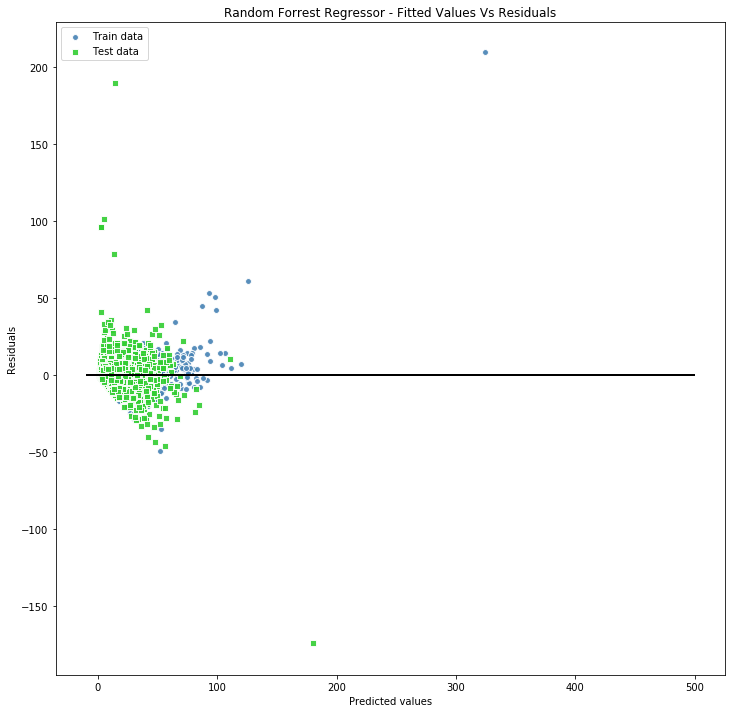

In [141]:
plt.figure(figsize = (12,12))

plt.scatter(y1_pred_train_rf,residuals_train_rf,
               c='steelblue',
                edgecolor='white',
                marker='o',
                s=35,
                alpha=0.9,
                label='Train data')


plt.scatter(y1_pred_test_rf,residuals_test_rf,
                c='limegreen',
                edgecolor='white',
                marker='s',
                s=35,
                alpha=0.9,
                label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title("Random Forrest Regressor - Fitted Values Vs Residuals")
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=500, lw=2, color='black')
#plt.xlim([-10, 50])
plt.show()

### With Standardised Train and test data

In [142]:
# Random Forest Regressor

forest2 = RandomForestRegressor(n_estimators=1000,
                                    criterion='mse',
                                    random_state=1,
                                    n_jobs=-1)


rfmodel2 = forest2.fit(X1_train_std, y1_train_std)

# Predicting a new result for test data 
y1_pred_train_rf2 = forest2.predict(X1_train_std)


# Predicting a new result for test data 
y1_pred_test_rf2 = forest2.predict(X1_test_std)

#### Evaluating Random Forest Regression on scaled version of trained dataset

In [143]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error is : ", mean_absolute_error(y1_train_std, y1_pred_train_rf2))

#Mean Squared Error
from sklearn.metrics import mean_squared_error
print("Mean Squared Error : ", mean_squared_error(y1_train_std, y1_pred_train_rf2))

#R² Score
from sklearn.metrics import r2_score
print("R-square value : ", r2_score(y1_train_std, y1_pred_train_rf2))

Mean Absolute Error is :  0.11741608329510012
Mean Squared Error :  0.05351012248422139
R-square value :  0.9464898775157786


#### Evaluating Random Forest Regression on scaled version of test dataset

In [144]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error is : ", mean_absolute_error(y1_test_std, y1_pred_test_rf2))

#Mean Squared Error
from sklearn.metrics import mean_squared_error
print("Mean Squared Error : ", mean_squared_error(y1_test_std, y1_pred_test_rf2))

#R² Score
from sklearn.metrics import r2_score
print("R-square value : ", r2_score(y1_test_std, y1_pred_test_rf2))

Mean Absolute Error is :  0.3322798597501033
Mean Squared Error :  0.3405150210490167
R-square value :  0.6594849789509833


When I used the scaled data set, the evaluation metric - Mean Absolute Error is much better, without loosing the variance power (R-sqaure) - almost 66%

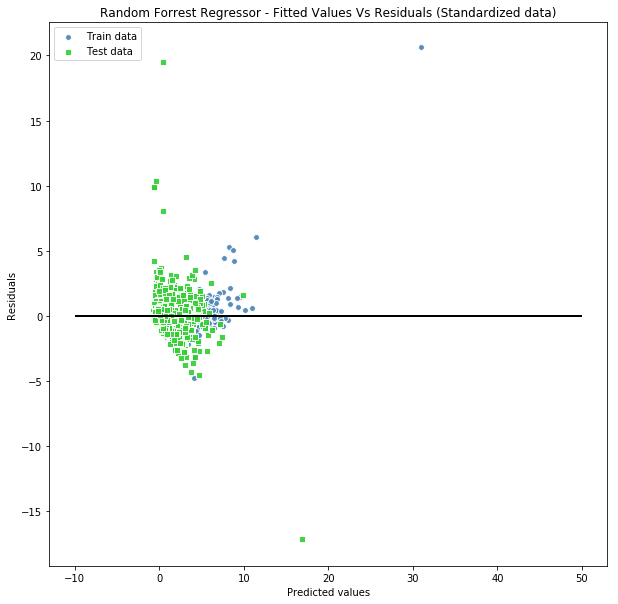

In [145]:

# plotting residuals to see a pattern
residuals_train_rf2 = y1_train_std - y1_pred_train_rf2 # actual test value - predicted value

# plotting residuals to see a pattern
residuals_test_rf2 = y1_test_std - y1_pred_test_rf2 # actual test value - predicted value


plt.figure(figsize = (10,10))

plt.scatter(y1_pred_train_rf2,residuals_train_rf2,
               c='steelblue',
                edgecolor='white',
                marker='o',
                s=35,
                alpha=0.9,
                label='Train data')


plt.scatter(y1_pred_test_rf2,residuals_test_rf2,
                c='limegreen',
                edgecolor='white',
                marker='s',
                s=35,
                alpha=0.9,
                label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title("Random Forrest Regressor - Fitted Values Vs Residuals (Standardized data)")
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
#plt.xlim([-10, 50])
plt.show()

The residual plot still explains the variance of the Random Forest Regressor. 

Final selection of the model is - Random Forest Regressor with scaled data set

## Predicting the values for the 2nd dependant variable -  Incoming bikes 

#### Feature Scaling (for 2nd dependant variable)

In [146]:
# Defining targets
target2 = summarydf_features1['incomingbikes'] # Trips that started from that station

# splitting data into train (75%) and test (25%)
# for second dependant variable - target2
X1_train, X1_test, y2_train, y2_test = train_test_split(features1, target2, test_size = 0.25, random_state = 0)

# Feature Scaling
sc_x = StandardScaler()
X1_train_std = sc_x.fit_transform(X1_train)
X1_test_std = sc_x.transform(X1_test)

sc_y = StandardScaler()
y2_train_std = sc_y.fit_transform(y2_train[:, np.newaxis]).flatten()
y2_test_std = sc_y.fit_transform(y2_test[:, np.newaxis]).flatten()


#### Building Model

In [147]:
# Random Forest Regressor

forest3 = RandomForestRegressor(n_estimators=1000,
                                    criterion='mse',
                                    random_state=1,
                                    n_jobs=-1)


rfmodel3 = forest3.fit(X1_train_std, y2_train_std)

# Predicting a new result for test data 
y2_pred_train_rf3 = forest3.predict(X1_train_std)


# Predicting a new result for test data 
y2_pred_test_rf3 = forest3.predict(X1_test_std)

#### Evaluating model for 2nd variable with training data set

In [148]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error is : ", mean_absolute_error(y2_train_std, y2_pred_train_rf3))

#Mean Squared Error
from sklearn.metrics import mean_squared_error
print("Mean Squared Error : ", mean_squared_error(y2_train_std, y2_pred_train_rf3))

#R² Score
from sklearn.metrics import r2_score
print("R-square value : ", r2_score(y2_train_std, y2_pred_train_rf3))

Mean Absolute Error is :  0.10609099755571129
Mean Squared Error :  0.060603830693120544
R-square value :  0.9393961693068794


#### Evaluating model for 2nd variable with test data set

In [149]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error is : ", mean_absolute_error(y2_test_std, y2_pred_test_rf3))

#Mean Squared Error
from sklearn.metrics import mean_squared_error
print("Mean Squared Error : ", mean_squared_error(y2_test_std, y2_pred_test_rf3))

#R² Score
from sklearn.metrics import r2_score
print("R-square value : ", r2_score(y2_test_std, y2_pred_test_rf3))

Mean Absolute Error is :  0.32475584925063145
Mean Squared Error :  0.4119098603467303
R-square value :  0.5880901396532696


The above evaluation confirms our expectation that the model fits almost perfectly for training data set with Mean Absolute Error or 0.106, while test data set has MAE of 0.32. The model explains the variance in dependant variable upto 58%

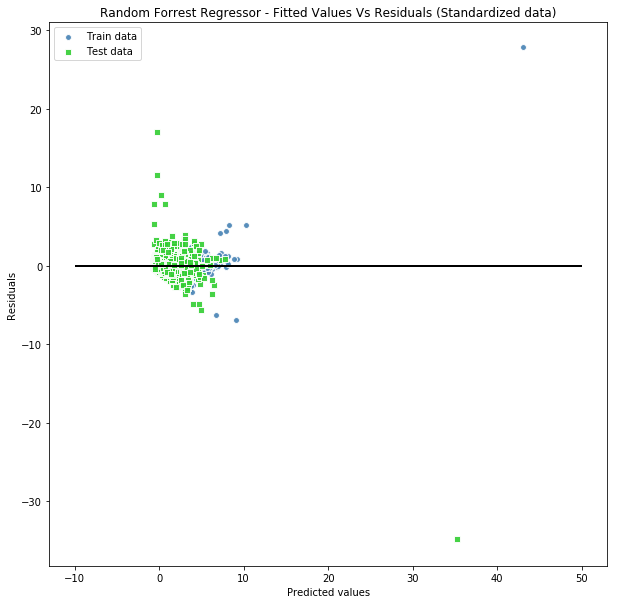

In [150]:

# plotting residuals to see a pattern
residuals_train_rf3 = y2_train_std - y2_pred_train_rf3 # actual test value - predicted value

# plotting residuals to see a pattern
residuals_test_rf3 = y2_test_std - y2_pred_test_rf3 # actual test value - predicted value


plt.figure(figsize = (10,10))

plt.scatter(y2_pred_train_rf3,residuals_train_rf3,
               c='steelblue',
                edgecolor='white',
                marker='o',
                s=35,
                alpha=0.9,
                label='Train data')


plt.scatter(y2_pred_test_rf3,residuals_test_rf3,
                c='limegreen',
                edgecolor='white',
                marker='s',
                s=35,
                alpha=0.9,
                label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title("Random Forrest Regressor - Fitted Values Vs Residuals (Standardized data)")
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
#plt.xlim([-10, 50])
plt.show()

As no pattern can be observed from the above residual vs predicted value for 2nd dependant variable (Incoming bikes), we can safely assume that the model explains well

# 2) Unsupervied - Clustering of the stations

#### Problem Statement

Using unsupervised learning, cluster the stations and find the key influencers for the trip count.

We will start with the `summarydf` data frame and refine the features. 

For clustering, we decided to exclude the status column. Since status is specific to the time of acquiring the data, dropping record based on status or using status as a feature might lead to data loss or inaccuracy.

In [151]:
# create mapping for days

numdays = {'day_of_week': {'Monday': 1,
                           'Tuesday': 2,
                           'Wednesday': 3,
                           'Thursday': 4,
                           'Friday': 5,
                           'Saturday': 6,
                           'Sunday': 7}}

# drop column that will not be used

basedf = summarydf.drop(['Status'], axis=1)


# replace day names by numbers (weeks starts on Monday - 1)

basedf.replace(numdays, inplace=True)

basedf.head()

,Station_ID,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag,totaltrips
0,3000,1,2.0,24.0,48.535714,58.910714,70.392857,2018,1,1,26.0
1,3005,1,13.0,11.0,48.535714,58.910714,70.392857,2018,1,1,24.0
2,3006,1,15.0,11.0,48.535714,58.910714,70.392857,2018,1,1,26.0
3,3007,1,10.0,6.0,48.535714,58.910714,70.392857,2018,1,1,16.0
4,3008,1,2.0,10.0,48.535714,58.910714,70.392857,2018,1,1,12.0


We plan to use unsupervised learning and need to convert the columns into integer columns. For that purpose, the following adjustments are needed in the data.

* `totaltrips` needed to be converted to integer.
* `tavg` will be encoded and used as the only feature for temperature.
* `Station_ID` will be dropped

In [152]:
# Drop unnecessary columns

dropcols = ['Station_ID','outgoingbikes','incomingbikes','tmin','tmax']
featuredf = basedf.copy()
featuredf.drop(dropcols,inplace=True,axis=1)

# Convert to int
featuredf = featuredf.astype('int64', copy=False)

featuredf.head()

,day_of_week,tavg,year,month,holidayflag,totaltrips
0,1,58,2018,1,1,26
1,1,58,2018,1,1,24
2,1,58,2018,1,1,26
3,1,58,2018,1,1,16
4,1,58,2018,1,1,12


For the purpose of predicting sation cluster, we would apply unsupervised learning, _k-means_ to be precise.

In [153]:
# keep only relevant columns

dropcols = ['tmin','tmax','year','month','holidayflag','day_of_week','outgoingbikes','incomingbikes']
featuredf = basedf.copy()
featuredf.drop(dropcols,inplace=True,axis=1)

featuredf.head()

,Station_ID,tavg,totaltrips
0,3000,58.910714,26.0
1,3005,58.910714,24.0
2,3006,58.910714,26.0
3,3007,58.910714,16.0
4,3008,58.910714,12.0


In [154]:
# encode totaltrips to traffic - high, medium, low

prepdf = featuredf[["Station_ID", "totaltrips","tavg"]].groupby(['Station_ID'], as_index=False) \
.mean().sort_values(by='totaltrips', ascending=False)

# light traffic
prepdf.loc[prepdf.totaltrips < 50.0, 'traffic' ] = 0
# medium traffic
prepdf.loc[(prepdf.totaltrips >= 50.0) & (prepdf.totaltrips < 100.0), 'traffic'] = 1
# high traffic
prepdf.loc[prepdf.totaltrips >= 100.0, 'traffic' ] = 2

prepdf.head()

,Station_ID,totaltrips,tavg,traffic
131,4276,303.000000,52.892857,2.0
171,4356,180.000000,54.892857,2.0
172,4357,113.000000,54.892857,2.0
115,4214,77.840095,63.544157,1.0
1,3005,69.830769,62.992444,1.0


In [155]:
# test train split

msk = np.random.rand(len(prepdf)) < 0.8
train = prepdf[msk]
test = prepdf[~msk]
test.drop('totaltrips',inplace=True,axis=1)

print(len(prepdf))
print(len(test))
print(len(train))

183
46
137


In [156]:
# create dependent and independent varibales

X = np.array(train.drop(['traffic','totaltrips','tavg'], 1).astype(float))
y = np.array(train['traffic'])

# we want to cluster the stations into 3: low, medium and high traffic
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [157]:
# look at the number of stations clusterd correctly

correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.35036496350364965


To improve the performance of the model we are tweaking some parameters. Following parameters will be tweaked and the model will be fit again:
algorithm, max_iter and n_jobs.

In [158]:
# fit model with altered parameters

kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [159]:
correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.35036496350364965


As a practice, we would like to scale the values in the dataset so that changes in feature values have least influence on each other.

In [161]:
# scale feature values
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

kmeans.fit(X_scaled)

correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.014598540145985401


# 3) Classifying the trips based on passholder Type

In [162]:
# Visualizing the first five rows of the trip_merged dataset

trip_merged.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,start_region,start_status,end_region,end_status,date,tmin,tavg,tmax,minutes,day_of_week
0,112536773,7,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
1,112536772,6,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
2,112538689,32,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,1,Tuesday
3,112538688,30,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
4,112538687,28,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday


In [163]:
# Checking the column names for the trip merged dataset

trip_merged.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'start_region', 'start_status', 'end_region', 'end_status',
       'date', 'tmin', 'tavg', 'tmax', 'minutes', 'day_of_week'],
      dtype='object')

In [164]:
# Checking teh number of different types of pass holder types

trip_merged.passholder_type.unique()

array(['Walk-up', 'Monthly Pass', 'Annual Pass', 'One Day Pass',
       'Flex Pass', 'Testing'], dtype=object)

In [165]:
# The goal of the experiment is to classify the dataset based on the passholder type 
# i.e. in other words predicting pass holder tyype

trip_merged.passholder_type.value_counts()

Monthly Pass    190987
Walk-up         145249
One Day Pass     20108
Flex Pass         7021
Annual Pass       5876
Testing             11
Name: passholder_type, dtype: int64

In [166]:
# Since the dataset is imbalanced between different pass holder type, I am going to collect the data corresponding to the highest two
# I am going to call the new data frame with only two pass holder types - Monthly_WalkUp dataframe

monthly_walkup = trip_merged[(trip_merged['passholder_type']=='Monthly Pass') | (trip_merged['passholder_type']== 'Walk-up')]

In [167]:
# Checking the shape of the new dataframe i.e monthly_walkup

monthly_walkup.shape

(336236, 25)

In [168]:
# Checking the unique types of pass holder type
# As we can see, now the data frame has only two types of data

monthly_walkup.passholder_type.value_counts()

Monthly Pass    190987
Walk-up         145249
Name: passholder_type, dtype: int64

In [169]:
# Model Building
# Problem Statement: Predicting whether a pass holder has a monthly pass or walk up type
# Classification Model- Random Forests

In [170]:
# Mapping the pass holder type variable into numerics

monthly_walkup['passholder_type'].replace(['Monthly Pass','Walk-up'],[0,1],inplace=True)

In [171]:
# Checking the monthly pass holder type to see if it is mapped correctly

monthly_walkup.passholder_type.unique()

array([1, 0], dtype=int64)

In [172]:
# Attribute selection for the model
# dropping the columns that may not effect teh classification

monthly_walkup.drop(['trip_id', 'start_time', 'end_time', 'start_lat', 'start_lon', 'end_station', 
                     'end_lat', 'bike_id', 'start_status', 'end_region', 'end_status', 'date'], axis=1, inplace=True)

In [173]:
# Visualizing the current state of the dataset
monthly_walkup.drop(['end_lon'],axis=1, inplace=True)
monthly_walkup.dtypes

duration                 int64
start_station            int64
plan_duration            int64
trip_route_category     object
passholder_type          int64
bike_type               object
start_region            object
tmin                   float64
tavg                   float64
tmax                   float64
minutes                  int32
day_of_week             object
dtype: object

In [174]:
# Checking for nan values

monthly_walkup.isnull().sum()

duration                    0
start_station               0
plan_duration               0
trip_route_category         0
passholder_type             0
bike_type              216864
start_region              706
tmin                        0
tavg                        0
tmax                        0
minutes                     0
day_of_week                 0
dtype: int64

In [175]:
# Based on the percentage of null values, dropping the bike type column

monthly_walkup.drop(['bike_type'],axis=1, inplace=True)

In [176]:
# dropping rows with null values

monthly_walkup.dropna(axis=0, how='any', inplace = True)

In [177]:
# Checking for nan values

monthly_walkup.isnull().values.any()

False

In [178]:
# Converting the object variables and get dummies for the model

monthly_walkup = pd.get_dummies(monthly_walkup, columns = ['trip_route_category','start_region'], drop_first = True)

In [179]:
# converting start station to categorical

monthly_walkup['start_station'] = monthly_walkup['start_station'].astype('category')

In [180]:
# Converting the object variables and get dummies for the model

monthly_walkup = pd.get_dummies(monthly_walkup, columns = ['day_of_week'], drop_first = True)

In [181]:
# Shape of the final dataset

monthly_walkup.shape

(335530, 19)

In [182]:
# Visualizing the final dataset before fitting the model

monthly_walkup.head()

,duration,start_station,plan_duration,passholder_type,tmin,tavg,tmax,minutes,trip_route_category_Round Trip,start_region_Free Bikes,start_region_Pasadena,start_region_Port of LA,start_region_Westside,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,7,3046,1,1,39.888889,47.851852,55.740741,0,0,0,0,0,0,0,0,0,0,1,0
1,6,3046,1,1,39.888889,47.851852,55.740741,0,0,0,0,0,0,0,0,0,0,1,0
2,32,3030,1,1,39.888889,47.851852,55.740741,1,0,0,0,0,0,0,0,0,0,1,0
3,30,3030,1,1,39.888889,47.851852,55.740741,0,0,0,0,0,0,0,0,0,0,1,0
4,28,3030,1,1,39.888889,47.851852,55.740741,0,0,0,0,0,0,0,0,0,0,1,0


In [183]:
# Visualizing the final dataset before fitting the model

monthly_walkup.head()

,duration,start_station,plan_duration,passholder_type,tmin,tavg,tmax,minutes,trip_route_category_Round Trip,start_region_Free Bikes,start_region_Pasadena,start_region_Port of LA,start_region_Westside,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,7,3046,1,1,39.888889,47.851852,55.740741,0,0,0,0,0,0,0,0,0,0,1,0
1,6,3046,1,1,39.888889,47.851852,55.740741,0,0,0,0,0,0,0,0,0,0,1,0
2,32,3030,1,1,39.888889,47.851852,55.740741,1,0,0,0,0,0,0,0,0,0,1,0
3,30,3030,1,1,39.888889,47.851852,55.740741,0,0,0,0,0,0,0,0,0,0,1,0
4,28,3030,1,1,39.888889,47.851852,55.740741,0,0,0,0,0,0,0,0,0,0,1,0


In [184]:
# Getting the X and y values from the dataframe

X = monthly_walkup.loc[:, monthly_walkup.columns != 'passholder_type']
y = monthly_walkup.loc[:,'passholder_type']

In [185]:
# Importing the test and train split library

from sklearn.model_selection import train_test_split

# Splitting the dataset into test and train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [186]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [187]:
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [188]:
# Getting the predictions for the X_test
y_pred = classifier.predict(X_test)

In [189]:
# Calculating the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[37962,   149],
       [  439, 28556]], dtype=int64)

In [190]:
# Calculating area under the curve
from sklearn import metrics
metrics.roc_auc_score(y_test, y_pred)

0.9904749130688667

In [191]:
# Calculating the accuracies from 3 fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train,  y = y_train, n_jobs = -1, cv = 5)
accuracies.mean()

0.9917145958372169